In [136]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_recall_fscore_support
from sklearn.metrics import classification_report
import fastdtw
from scipy.spatial.distance import euclidean
from nltk.cluster import KMeansClusterer,cosine_distance
import scipy.spatial.distance as sd
from sklearn.cluster import KMeans
from sklearn import metrics
from sklearn.decomposition import PCA
from sklearn import mixture
from sklearn import manifold
from sklearn.preprocessing import StandardScaler

In [43]:
data = pd.read_csv('sentiment_score.csv')
data = data.dropna()
data

,AFRAID,AMUSED,ANGRY,ANNOYED,DONT_CARE,HAPPY,INSPIRED,SAD
0,0.092794,0.114177,0.116472,0.132365,0.129963,0.105839,0.201247,0.107143
1,0.108238,0.111975,0.121799,0.134885,0.129981,0.107100,0.178588,0.107434
2,0.093672,0.123894,0.115410,0.138560,0.138518,0.108802,0.179580,0.101564
3,0.105926,0.106197,0.128772,0.134356,0.121305,0.108597,0.182394,0.112452
4,0.108617,0.112215,0.118959,0.129735,0.126809,0.107173,0.184243,0.112248
...,...,...,...,...,...,...,...,...
2462,0.102343,0.108939,0.131899,0.138636,0.126494,0.101510,0.174694,0.115485
2463,0.120188,0.119194,0.114707,0.126044,0.117753,0.104346,0.175029,0.122739
2464,0.097120,0.131195,0.119608,0.129501,0.123598,0.106018,0.193803,0.099157
2465,0.094750,0.117907,0.122510,0.136626,0.131677,0.101304,0.191245,0.103982


In [112]:
distance_matrix = []
m = len(data)    
for i in range(0, m - 1):
    for j in range(i + 1, m):
        distance, path = fastdtw.fastdtw(data.iloc[i,:], data.iloc[j,:],dist=euclidean)
        distance_matrix.append(distance)
len(distance_matrix)

3029491

In [114]:
len(distance_matrix)

3029491

In [115]:
dtm = np.array(distance_matrix)
dtm = np.expand_dims(dtm,axis=1)
dtm.shape

(3029491, 1)

In [48]:
train, test = train_test_split(data, test_size=0.2, random_state=0)

### Model 1: Kmeans

In [116]:
num_clusters = 8

km = KMeans(n_clusters=num_clusters, n_init=20, random_state = 42).fit(dtm)
clusters = km.labels_.tolist()

In [125]:
km_cluster = pd.DataFrame(data=clusters,columns=['km_sentiment_cluster'])
km_cluster[0:5]

,km_sentiment_cluster
0,2
1,0
2,6
3,2
4,7


In [127]:
km_cluster.shape

(3029491, 1)

In [126]:
km_cluster.to_csv('km_cluster.csv',index=False)

In [128]:
km_cluster = pd.read_csv('km_cluster.csv')
km_cluster

,km_sentiment_cluster
0,2
1,0
2,6
3,2
4,7
...,...
3029486,1
3029487,6
3029488,2
3029489,2


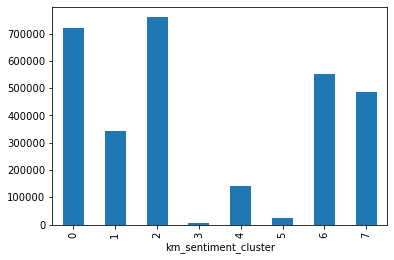

In [134]:
km2 = km_cluster.groupby('km_sentiment_cluster').km_sentiment_cluster.count()
km2.plot(kind='bar')
plt.show()

In [96]:
test_matrix = []
m = len(test)    
for i in range(0, m - 1):
    for j in range(i + 1, m):
        distance, path = fastdtw.fastdtw(test.iloc[i,:], test.iloc[j,:],dist=euclidean)
        test_matrix.append(distance)
len(test_matrix)

121278

In [99]:
test_dtm = np.array(test_matrix)
test_dtm = np.expand_dims(test_dtm,axis=1)
test_dtm.shape

(121278, 1)

In [118]:
predicted = km.predict(test_dtm)
predicted

array([6, 2, 6, ..., 2, 2, 0])

### Model 2: Gaussian Mixture Models (GMMs)

In [119]:
lowest_bic = np.infty   # initial BIC is set to infinity
best_gmm = None

n_components_range = range(2,10)    # The number of clusters

cv_types = ['spherical', 'tied', 'diag']  # The covariance type, for details check https://scikit-learn.org/stable/modules/generated/sklearn.mixture.GaussianMixture.html#sklearn.mixture.GaussianMixture.aic

for cv_type in cv_types:
    
    for n_components in n_components_range:
        
        # Fit a Gaussian mixture with EM
        gmm = mixture.GaussianMixture(n_components=n_components,
                                      covariance_type=cv_type, random_state=42)
        gmm.fit(dtm)
        
        bic = gmm.bic(dtm)  # get Model BIC
        
        if bic < lowest_bic:  # save the model with lowest BIC sofar
            lowest_bic = bic
            best_gmm = gmm


In [122]:
print(lowest_bic)
best_gmm

-13876012.714595705


GaussianMixture(covariance_type='spherical', n_components=9, random_state=42)

In [121]:
predicted = best_gmm.predict(test_dtm)
predicted[0:5]

array([7, 4, 7, 4, 1], dtype=int64)

In [137]:
data2 = StandardScaler(with_std=True).fit_transform(data)

In [140]:
mds = manifold.MDS(n_components=2, max_iter=3000, eps=1e-9, random_state=123,
                   dissimilarity="euclidean", n_jobs=1)
data_mds2 = mds.fit(data2).embedding_


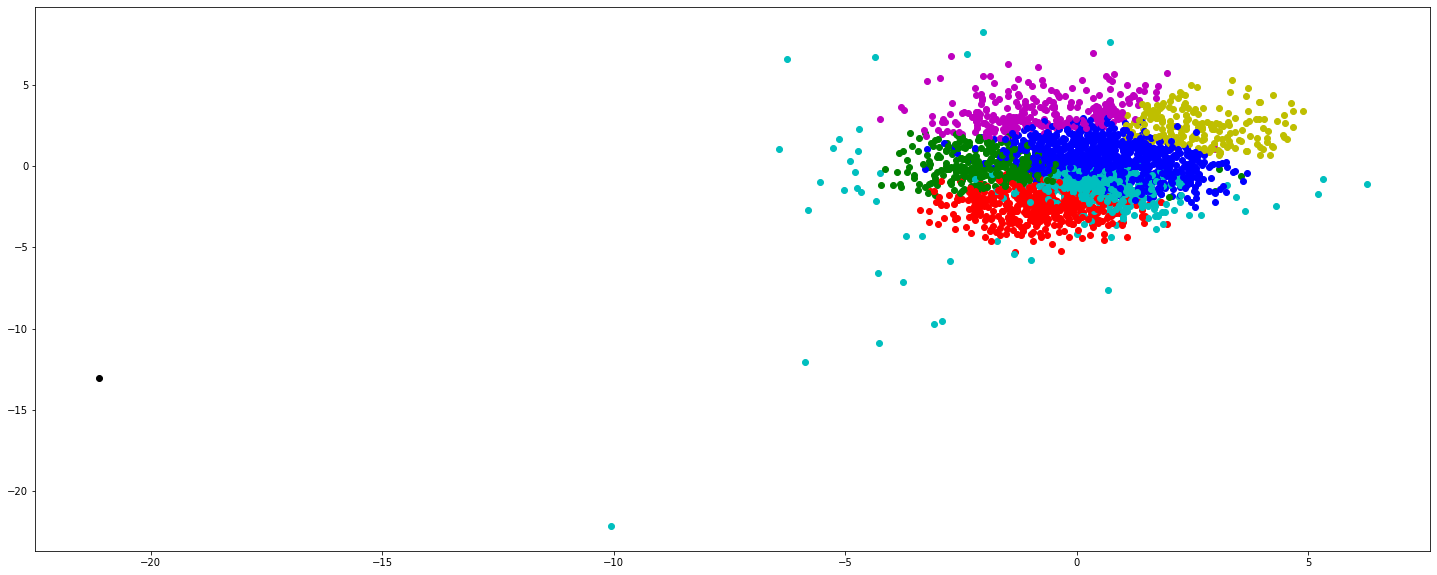

In [154]:
best_gmm.fit(data2)
cluster_gmm = best_gmm.predict(data2)
colors = np.array([x for x in 'bgrcmykcb'])
color = colors[cluster_gmm]
plt.figure(figsize=(25, 10))
#scatter plot
for x, y, c in zip(data_mds2[:,0], data_mds2[:,1], color):
    plt.scatter(x,y,color=c)

In [163]:
cluster_gmm2 = pd.DataFrame(data=cluster_gmm,columns=['sentiment_cluster'])
cluster_gmm2

,sentiment_cluster
0,3
1,8
2,2
3,0
4,0
...,...
2457,5
2458,4
2459,1
2460,8


In [180]:
data2 = pd.read_csv('sentiment_tran.csv')
data2

,transcript,url,AFRAID,AMUSED,ANGRY,ANNOYED,DONT_CARE,HAPPY,INSPIRED,SAD
0,Good morning. How are you?(Laughter)It's been ...,https://www.ted.com/talks/ken_robinson_says_sc...,0.092794,0.114177,0.116472,0.132365,0.129963,0.105839,0.201247,0.107143
1,"Thank you so much, Chris. And it's truly a gre...",https://www.ted.com/talks/al_gore_on_averting_...,0.108238,0.111975,0.121799,0.134885,0.129981,0.107100,0.178588,0.107434
2,"(Music: ""The Sound of Silence,"" Simon & Garfun...",https://www.ted.com/talks/david_pogue_says_sim...,0.093672,0.123894,0.115410,0.138560,0.138518,0.108802,0.179580,0.101564
3,If you're here today — and I'm very happy that...,https://www.ted.com/talks/majora_carter_s_tale...,0.105926,0.106197,0.128772,0.134356,0.121305,0.108597,0.182394,0.112452
4,"About 10 years ago, I took on the task to teac...",https://www.ted.com/talks/hans_rosling_shows_t...,0.108617,0.112215,0.118959,0.129735,0.126809,0.107173,0.184243,0.112248
...,...,...,...,...,...,...,...,...,...,...
2462,"So, Ma was trying to explain something to me a...",https://www.ted.com/talks/duarte_geraldino_wha...,0.102343,0.108939,0.131899,0.138636,0.126494,0.101510,0.174694,0.115485
2463,This is a picture of a sunset on Mars taken by...,https://www.ted.com/talks/armando_azua_bustos_...,0.120188,0.119194,0.114707,0.126044,0.117753,0.104346,0.175029,0.122739
2464,"In my early days as a graduate student, I went...",https://www.ted.com/talks/radhika_nagpal_what_...,0.097120,0.131195,0.119608,0.129501,0.123598,0.106018,0.193803,0.099157
2465,I took a cell phone and accidentally made myse...,https://www.ted.com/talks/theo_e_j_wilson_a_bl...,0.094750,0.117907,0.122510,0.136626,0.131677,0.101304,0.191245,0.103982


In [181]:
print(data2[data2.isnull().any(axis=1)].head())

                                             transcript  \
146                         (Applause)(Music)(Applause)   
908                  (Music)(Applause)(Music)(Applause)   
1173  (Music)(Applause)(Music)(Applause)(Music)(Appl...   
1796                                  (Music)(Applause)   
1919                (Music)(Music) (Applause)(Applause)   

                                                    url  AFRAID  AMUSED  \
146   https://www.ted.com/talks/kenichi_ebina_s_magi...     NaN     NaN   
908   https://www.ted.com/talks/robert_gupta_and_jos...     NaN     NaN   
1173  https://www.ted.com/talks/quixotic_fusion_danc...     NaN     NaN   
1796  https://www.ted.com/talks/aakash_odedra_a_danc...     NaN     NaN   
1919  https://www.ted.com/talks/joey_alexander_an_11...     NaN     NaN   

      ANGRY  ANNOYED  DONT_CARE  HAPPY  INSPIRED  SAD  
146     NaN      NaN        NaN    NaN       NaN  NaN  
908     NaN      NaN        NaN    NaN       NaN  NaN  
1173    NaN      NaN      

In [197]:
data3 = data2.dropna()
data3.to_csv('sent_tran_na.csv',index=False)

In [198]:
data3 = pd.read_csv('sent_tran_na.csv')
data3

,transcript,url,AFRAID,AMUSED,ANGRY,ANNOYED,DONT_CARE,HAPPY,INSPIRED,SAD
0,Good morning. How are you?(Laughter)It's been ...,https://www.ted.com/talks/ken_robinson_says_sc...,0.092794,0.114177,0.116472,0.132365,0.129963,0.105839,0.201247,0.107143
1,"Thank you so much, Chris. And it's truly a gre...",https://www.ted.com/talks/al_gore_on_averting_...,0.108238,0.111975,0.121799,0.134885,0.129981,0.107100,0.178588,0.107434
2,"(Music: ""The Sound of Silence,"" Simon & Garfun...",https://www.ted.com/talks/david_pogue_says_sim...,0.093672,0.123894,0.115410,0.138560,0.138518,0.108802,0.179580,0.101564
3,If you're here today — and I'm very happy that...,https://www.ted.com/talks/majora_carter_s_tale...,0.105926,0.106197,0.128772,0.134356,0.121305,0.108597,0.182394,0.112452
4,"About 10 years ago, I took on the task to teac...",https://www.ted.com/talks/hans_rosling_shows_t...,0.108617,0.112215,0.118959,0.129735,0.126809,0.107173,0.184243,0.112248
...,...,...,...,...,...,...,...,...,...,...
2457,"So, Ma was trying to explain something to me a...",https://www.ted.com/talks/duarte_geraldino_wha...,0.102343,0.108939,0.131899,0.138636,0.126494,0.101510,0.174694,0.115485
2458,This is a picture of a sunset on Mars taken by...,https://www.ted.com/talks/armando_azua_bustos_...,0.120188,0.119194,0.114707,0.126044,0.117753,0.104346,0.175029,0.122739
2459,"In my early days as a graduate student, I went...",https://www.ted.com/talks/radhika_nagpal_what_...,0.097120,0.131195,0.119608,0.129501,0.123598,0.106018,0.193803,0.099157
2460,I took a cell phone and accidentally made myse...,https://www.ted.com/talks/theo_e_j_wilson_a_bl...,0.094750,0.117907,0.122510,0.136626,0.131677,0.101304,0.191245,0.103982


In [202]:
data4 = pd.concat([data3['url'], cluster_gmm2],axis=1,join= 'outer') 
data4

,url,sentiment_cluster
0,https://www.ted.com/talks/ken_robinson_says_sc...,3
1,https://www.ted.com/talks/al_gore_on_averting_...,8
2,https://www.ted.com/talks/david_pogue_says_sim...,2
3,https://www.ted.com/talks/majora_carter_s_tale...,0
4,https://www.ted.com/talks/hans_rosling_shows_t...,0
...,...,...
2457,https://www.ted.com/talks/duarte_geraldino_wha...,5
2458,https://www.ted.com/talks/armando_azua_bustos_...,4
2459,https://www.ted.com/talks/radhika_nagpal_what_...,1
2460,https://www.ted.com/talks/theo_e_j_wilson_a_bl...,8


In [201]:
data4.isnull().any()

transcript           False
url                  False
AFRAID               False
AMUSED               False
ANGRY                False
ANNOYED              False
DONT_CARE            False
HAPPY                False
INSPIRED             False
SAD                  False
sentiment_cluster    False
dtype: bool

In [205]:
data4.to_csv('sentiment_cluster_gmm.csv',index=False)